# Optimal State-Space Reconstruction Using Derivatives on Projected Manifold, Physical Review E 87, 022905

## Author: Chetan Nichkawde

In [2]:
%matplotlib inline

#### Generate data for Mackey-Glass equation

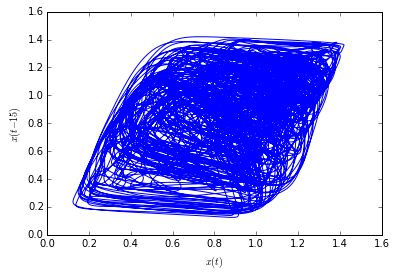

In [3]:
import numpy as np
import pylab as pl
from pydelay import dde23

eqns = { 
    'x' : 'beta * x(t-tau) / (1.0 + pow(x(t-tau),n)) -gamma*x' 
    }

params1 = {
    'beta'  : 0.2,
    'tau'   : 44,
    'n'     : 10.0,
    'gamma' : 0.1
    }

dde = dde23(eqns=eqns, params=params1)

Nt = 2000
dt = 0.5
N = 20000

N += Nt
tf = N*dt+515

dde.set_sim_params(tfinal=tf, dtmax=1)

histfunc = {
    'x': lambda t: 0.5
    } 
dde.hist_from_funcs(histfunc, 51)

dde.run()

sol1 = dde.sample(515, tf, dt)
x1 = sol1['x']

sol2 = dde.sample(500, tf-15, dt)
x2 = sol2['x']

pl.plot(x1, x2)
pl.xlabel('$x(t)$')
pl.ylabel('$x(t - 15)$')
pl.show()

ts = x1[Nt:]

## This is the implementation of the algorithm

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.ckdtree import cKDTree
from scipy.stats import gmean

plt.ion()

class Attractor(object):
    def __init__(self,ts1,maxdel=100,s=False,autoc=10):
        self.tlen = len(ts1)
        self.ts = (np.array(ts1)-np.mean(ts1))/np.std(ts1)
        self.autoc = autoc
        self.data = self.ts.reshape(self.tlen,1)
        self.dim = 1
        self.G = None
        self.maxdel = maxdel
        self.lags = [0]
        self.betaStat = []

        self.Rtol = 10
        self.fnnarr = []

    def embed(self):
        self.dim = len(self.lags)
        mlag = max(self.lags)
        dlen = len(self.ts)-np.max(self.lags)
        self.data = np.empty((dlen,self.dim))
        for i in range(dlen):
            for j in range(self.dim):
                self.data[i,j] = self.ts[i+mlag-self.lags[j]]

    def nnGraph(self):
        self.G = nx.Graph()
        dlen = self.data.shape[0]
        tree = cKDTree(self.data) 
        for idx in range(dlen):
            self.G.add_node(idx)
        for i in range(dlen):
            x = self.data[i,:]
            nnb = tree.query(x,k=80)
            nnarr = zip(nnb[0],nnb[1])
            for t in nnarr[1:]:
                if abs(i-t[1]) > self.autoc and t[0] != 0.0:
                    self.G.add_edge(i,t[1],weight=t[0])
                    break

    def mdop(self,tau):
        s = []
        flsenn = 0
        dlen = self.data.shape[0]
        mlag = max(self.lags)
        for e in self.G.edges(data=True):
            if (e[0]+mlag-tau) >= 0 and (e[1]+mlag-tau) >= 0:
                d2 = abs(self.ts[e[0]+mlag-tau]-self.ts[e[1]+mlag-tau])
                if d2 != 0:
                    s.append((d2/e[2]['weight']))
                    if s[-1] > self.Rtol:
                        flsenn += 1
        NNF = float(flsenn)/len(s)
        return gmean(s), NNF

    def reconstruct(self):
        self.nnGraph()
        while True:
            lg = 0
            print "DOF %d"%(len(self.lags)+1)
            arr = []
            FNN = []
            for i in range(1,self.maxdel+1):
                ep, flsenn = self.mdop(i)
                print i, ep
                arr.append(ep)
                FNN.append(flsenn)

            tailc = len(arr)-1
            mxidx = tailc
            while True:
                mxidx = arr.index(max(arr[:tailc+1]))
                if mxidx == tailc:
                    tailc -= 1
                else:
                    break
            lg = mxidx+1
            
            lg1 = raw_input("choose (%d)-> "%lg)
            if lg1.strip():
                lg = int(lg1.strip())
            self.lags.append(lg)
            self.betaStat.append(arr[lg-1])
            self.fnnarr.append(FNN[lg-1])
            print "lag dof %d = %d"%(len(self.lags),lg)
            print "FNN =", self.fnnarr
            print "All lags ", ",".join([str(l) for l in self.lags])
            
            plt.plot(range(1,len(arr)+1),np.log10(arr),label="m = %d"%(self.dim+1))
            plt.plot([lg],[np.log10(arr[lg-1])],'ro',linewidth=4)
            plt.xlabel(r"Delays ($\tau$)",fontsize=10)
            plt.ylabel(r"$\log_{10}\beta_d(\tau)$",fontsize=10)
#             plt.ylabel(r"$\left<\log \phi'_d\right>$",fontsize=20)
            plt.xticks(fontsize=10)
            #plt.yticks(visible=False)
#             plt.legend()
#             plt.subplots_adjust(bottom=0.12)
            br = raw_input("-> ")
            if br.strip() == "b":
                break
            if self.fnnarr[-1] < 0.00000001:
               del self.lags[-1]
               break
            self.dim += 1
            self.embed()
            self.nnGraph()

## Invoking the class above and doing the reconstruction

DOF 2
1 458.934458266
2 913.868271203
3 1353.57575238
4 1786.11866547
5 2210.46415368
6 2632.22084628
7 3038.13048969
8 3412.77725937
9 3795.0636679
10 4172.81129149
11 4536.38080482
12 4886.69571624
13 5227.62092977
14 5534.60381617
15 5832.34044111
16 6137.3396058
17 6443.61126141
18 6725.49682745
19 7011.058825
20 7267.16726712
21 7495.96911019
22 7732.62413821
23 7936.50979929
24 8147.72181136
25 8372.29236665
26 8560.77055214
27 8761.43946077
28 8930.70866438
29 9085.17547408
30 9227.30684165
31 9413.96084345
32 9569.00603759
33 9695.57769214
34 9755.93748292
35 9853.82058263
36 9990.6417856
37 10092.1668392
38 10132.1086683
39 10230.2299356
40 10405.0493602
41 10443.8357603
42 10482.9844089
43 10578.2577344
44 10657.4191398
45 10723.4875721
46 10799.0721119
47 10862.9202453
48 10897.3318211
49 11021.0897092
50 11026.7746527
51 11105.9903774
52 11084.1783466
53 11112.9825793
54 11112.4202075
55 11106.2355834
56 11107.0311093
57 11152.9559877
58 11134.6407493
59 11132.8143628
60 11

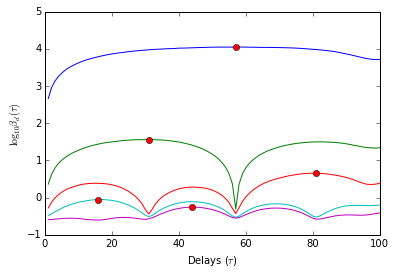

In [5]:
def rescale(x):
    xarr = np.copy(x)
    xarr -= np.min(x)
    xarr /= (np.max(x)-np.min(x))
    return xarr

attr = Attractor(rescale(ts),maxdel=100)
attr.reconstruct()

print "Embedding dimension =", len(attr.lags)
print ",".join([str(i) for i in attr.lags])